In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Feb 1 2024

@author: Yaning
"""

import math
import os
# from turtle import position
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.distributions import Beta, Binomial, HalfCauchy, Normal, Pareto, Uniform, Gamma
from tqdm import tqdm
import matplotlib.pyplot as plt
from statistics import mean 
# import pandas as pd

In [3]:
reward = torch.tensor(10.)
prior_mean = torch.tensor(0.)
prior_var = torch.tensor(3.)

In [5]:
def model(reward):
    # print("haha")
    # prior_mean = pyro.sample("prior_mean", Gamma(torch.tensor(1.), torch.tensor(2.)))
    # prior_var = pyro.sample("prior_var", Gamma(torch.tensor(2.), torch.tensor(1.)))
    # posterior_mean = torch.tensor(0.)
    # posterior_var = torch.tensor(3.)
    # observe = pyro.sample("observe", Normal(posterior_mean, posterior_var))
    pyro.sample("obs_", Normal(prior_mean, prior_var), obs=reward)

In [6]:
def guide(reward):
    posterior_mean_q = pyro.param("posterior_mean_q", prior_mean)
    posterior_var_q = pyro.param("posterior_var_q", prior_var)
    pyro.sample("observe", Normal(posterior_mean_q, posterior_var_q))

In [7]:
auto_g = pyro.infer.autoguide.AutoMultivariateNormal(model)

Mean ELBO  -0.20: 100%|██████████████████████████████████████████| 100/100 [00:00<00:00, 624.52it/s]


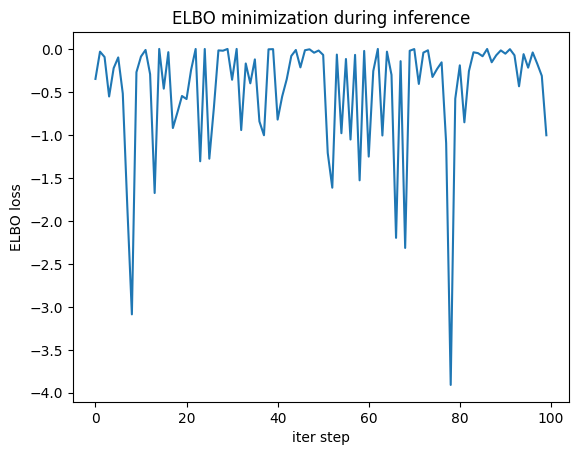

In [17]:
adam_params = {"lr": 500, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)


# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
# svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 100
loss = []
pbar = tqdm(range(n_steps), position = 0)
# do gradient steps
for step in pbar:
    loss.append(torch.tensor(svi.step(reward)))
    pbar.set_description("Mean ELBO %6.2f" % torch.tensor(loss[-20:]).mean())
    if torch.isnan(loss[-1]):
	    break

plt.figure()
plt.plot(loss)
plt.xlabel("iter step")
plt.ylabel("ELBO loss")
plt.title("ELBO minimization during inference")
plt.show()

In [12]:
dict = {}
for name, value in pyro.get_param_store().items():
    dict[name] = pyro.param(name)

In [13]:
dict

{'posterior_mean_q': tensor(-1034.4247, requires_grad=True),
 'posterior_var_q': tensor(3742.3452, requires_grad=True)}